<a href="https://colab.research.google.com/github/mystlee/2024_CSU_AI/blob/main/chapter9/CBOW_SkipGram_examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!apt-get update -qq
!apt-get install fonts-nanum* -qq
!fc-cache -fv

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import defaultdict
import itertools

corpus = [
    "나는 지금 친구와 학교에 가고 있다",
    "나는 학교에서 친구와 집에 가는 중에 있다",
    "학교에 가면 많은 친구들을 만날 수 있다",
    "오늘 너무 피곤해서 하루 종일 쉬고 싶다"
]

tokenized_corpus = [sentence.split() for sentence in corpus]

# word set (한국어)
vocab = set(itertools.chain(*tokenized_corpus))
word_to_ix = {word: i for i, word in enumerate(vocab)}
ix_to_word = {i: word for word, i in word_to_ix.items()}
vocab_size = len(vocab)

print(f"Vocab Size: {vocab_size}")
print("단어 인덱스 매핑:", word_to_ix)

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 39 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/nanum: skipping, looped dire

In [7]:
# context window size -> 3
window_size = 3

# CBOW와 Skip-gram용 데이터 생성
def generate_cbow_skipgram(tokenized_corpus, word_to_ix, window_size):
    cbow_data = []
    skipgram_data = []
    for sentence in tokenized_corpus:
        sentence_length = len(sentence)
        for i, target_word in enumerate(sentence):
            context = []
            # context window 범위 내의 word 수집
            for j in range(i - window_size, i + window_size + 1):
                if j != i and 0 <= j < sentence_length:
                    context.append(word_to_ix[sentence[j]])
            if context:
                cbow_data.append((context, word_to_ix[target_word]))
                for ctx_word in context:
                    skipgram_data.append((word_to_ix[target_word], ctx_word))
    return cbow_data, skipgram_data

cbow_data, skipgram_data = generate_cbow_skipgram(tokenized_corpus, word_to_ix, window_size)

print("\nCBOW 데이터 샘플:")
print(cbow_data[:5])

print("\nSkip-gram 데이터 샘플:")
print(skipgram_data[:5])


CBOW 데이터 샘플:
[([13, 5, 0], 2), ([2, 5, 0, 15], 13), ([2, 13, 0, 15, 14], 5), ([2, 13, 5, 15, 14], 0), ([13, 5, 0, 14], 15)]

Skip-gram 데이터 샘플:
[(2, 13), (2, 5), (2, 0), (13, 2), (13, 5)]


In [8]:
class CBOW(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(CBOW, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear = nn.Linear(embedding_dim, vocab_size)

    def forward(self, context_words):
        # context_words: [batch_size, context_size]
        embeds = self.embeddings(context_words)  # [batch_size, context_size, embedding_dim]
        embeds_mean = torch.mean(embeds, dim = 1)  # [batch_size, embedding_dim]
        out = self.linear(embeds_mean)  # [batch_size, vocab_size]
        log_probs = F.log_softmax(out, dim = 1)
        return log_probs


class SkipGram(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(SkipGram, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear = nn.Linear(embedding_dim, vocab_size)

    def forward(self, center_words):
        # center_words: [batch_size]
        embeds = self.embeddings(center_words)  # [batch_size, embedding_dim]
        out = self.linear(embeds)  # [batch_size, vocab_size]
        log_probs = F.log_softmax(out, dim = 1)
        return log_probs


In [9]:
embedding_dim = 16
epochs = 100
learning_rate = 0.01

# CBOW training!
cbow_model = CBOW(vocab_size, embedding_dim)
cbow_optimizer = optim.SGD(cbow_model.parameters(), lr=learning_rate)
cbow_loss_function = nn.NLLLoss()

for epoch in range(epochs):
    total_loss = 0
    for context, target in cbow_data:
        context_var = torch.tensor(context, dtype = torch.long).unsqueeze(0)
        target_var = torch.tensor([target], dtype = torch.long)

        cbow_optimizer.zero_grad()
        log_probs = cbow_model(context_var)
        loss = cbow_loss_function(log_probs, target_var)
        loss.backward()
        cbow_optimizer.step()

        total_loss += loss.item()
    if (epoch+1) % 20 == 0:
        print(f"CBOW Epoch {epoch+1}, Loss: {total_loss:.4f}")

# Skip-gram training!
skipgram_model = SkipGram(vocab_size, embedding_dim)
skipgram_optimizer = optim.SGD(skipgram_model.parameters(), lr=learning_rate)
skipgram_loss_function = nn.NLLLoss()

for epoch in range(epochs):
    total_loss = 0
    for center, context in skipgram_data:
        center_var = torch.tensor([center], dtype = torch.long)
        context_var = torch.tensor([context], dtype = torch.long)

        skipgram_optimizer.zero_grad()
        log_probs = skipgram_model(center_var)
        loss = skipgram_loss_function(log_probs, context_var)
        loss.backward()
        skipgram_optimizer.step()

        total_loss += loss.item()
    if (epoch+1) % 20 == 0:
        print(f"Skip-gram Epoch {epoch + 1}, Loss: {total_loss:.4f}")


CBOW Epoch 20, Loss: 72.5501
CBOW Epoch 40, Loss: 61.2583
CBOW Epoch 60, Loss: 52.0808
CBOW Epoch 80, Loss: 44.3982
CBOW Epoch 100, Loss: 37.9250
Skip-gram Epoch 20, Loss: 260.0801
Skip-gram Epoch 40, Loss: 227.6208
Skip-gram Epoch 60, Loss: 214.8633
Skip-gram Epoch 80, Loss: 209.6473
Skip-gram Epoch 100, Loss: 207.1475


In [10]:
def get_embeddings(model):
    return model.embeddings.weight.data.cpu().numpy()

cbow_embeddings = get_embeddings(cbow_model)
skipgram_embeddings = get_embeddings(skipgram_model)

print("\nCBOW embedding:")
for word, ix in word_to_ix.items():
    formatted = ', '.join(f"{x:.2f}" for x in cbow_embeddings[ix])
    print(f"{word}: [{formatted}]")

print("\nSkip-gram embedding:")
for word, ix in word_to_ix.items():
    formatted = ', '.join(f"{x:.2f}" for x in skipgram_embeddings[ix])
    print(f"{word}: [{formatted}]")



CBOW embedding:
학교에: [-0.44, -1.89, 0.97, -0.47, -1.56, -1.51, 1.85, -0.49, 1.46, -0.37, -1.51, 0.37, -0.71, -0.41, -2.30, 0.31]
종일: [0.34, 0.14, -0.39, 1.22, 0.82, 0.01, 0.13, 0.65, 2.09, 1.45, 2.05, 2.62, -2.39, -0.89, 0.82, -1.19]
나는: [2.48, -0.24, 1.09, -1.51, 0.73, -0.61, 0.19, -0.83, -1.89, 0.21, 1.32, -0.16, -0.78, 1.28, 0.21, -0.96]
가는: [0.02, 0.02, 0.24, 0.26, -0.43, 0.36, -1.06, -0.08, -0.16, -0.74, 0.59, -0.19, 0.15, -0.20, 1.46, -0.25]
피곤해서: [-0.19, 1.46, -0.84, -0.96, -0.04, 1.43, 0.68, 0.66, 1.31, -1.85, -1.12, -0.35, -0.89, -1.25, -0.55, -2.46]
친구와: [0.50, 0.93, 0.14, -1.68, -1.16, -0.19, 1.24, -0.00, -2.60, -1.87, -0.73, -1.71, 0.47, 0.20, 0.39, 0.14]
하루: [0.60, 0.16, 1.32, 0.57, -0.96, -0.69, 0.88, 0.09, -0.01, 0.89, -2.05, 0.05, 1.48, -1.09, 0.22, 1.23]
너무: [1.08, -0.11, -1.34, 0.15, 1.46, 1.63, -0.96, 0.58, -0.54, -0.66, -1.91, -1.01, -0.07, 0.80, -1.04, 0.59]
수: [-0.54, -0.06, -0.67, -0.62, 1.10, 0.94, 0.68, 1.07, -0.14, 0.12, -0.66, 0.34, -0.35, 0.11, -0.17, 1.06]

In [13]:
# 예시) CBOW 모델에서 "학교에서"를 중심 단어로 예측
target_word = "학교에서"
context_words = ["나는", "친구와"]

# word -> index (tensor)
context_indices = [word_to_ix[word] for word in context_words]
target_index = word_to_ix[target_word]
context_var = torch.tensor(context_indices, dtype = torch.long).unsqueeze(0)  # [1, context_size]
target_var = torch.tensor([target_index], dtype = torch.long)  # [1]

cbow_model.eval()
with torch.no_grad():
    log_probs = cbow_model(context_var)
    predicted_prob = torch.exp(log_probs)
    predicted_word = torch.argmax(predicted_prob, dim=1).item()

print(f"\nCBOW prediction")
print(f"context words: {context_words}")
print(f"pred. center words: {predicted_word}, 단어: {ix_to_word[predicted_word]}")
print(f"GT center word: {target_index}, 단어: {target_word}")



CBOW prediction
context words: ['나는', '친구와']
pred. center words: 19, 단어: 학교에서
GT center word: 19, 단어: 학교에서


In [16]:
# 예시) Skip-gram 모델에서 "학교에"를 중심 단어로 주변 단어 예측
center_word = "학교에서"
context_words = ["나는", "친구와"]

# word -> index (tensor)
center_index = word_to_ix[center_word]
context_indices = [word_to_ix[word] for word in context_words]
center_var = torch.tensor([center_index], dtype=torch.long)  # (1)

skipgram_model.eval()
with torch.no_grad():
    log_probs = skipgram_model(center_var)
    predicted_probs = torch.exp(log_probs)
    topk = torch.topk(predicted_probs, k=2, dim=1)
    predicted_indices = topk.indices[0].tolist()
    predicted_words = [ix_to_word[ix] for ix in predicted_indices]

print(f"\nSkip-gram 모델 예측:")
print(f"center words: {center_word}")
print(f"pred. context word: {predicted_words}")
print(f"GT context word: {context_words}")


Skip-gram 모델 예측:
center words: 학교에서
pred. context word: ['가는', '집에']
GT context word: ['나는', '친구와']


In [17]:
input_sentence = "나는 학교에서 친구와"
tokenized_input = input_sentence.split()
print(f"\n입력 문장: {input_sentence}")
print(f"토큰화된 입력: {tokenized_input}")



입력 문장: 나는 학교에서 친구와
토큰화된 입력: ['나는', '학교에서', '친구와']


In [18]:
input_indices = [word_to_ix[word] for word in tokenized_input]
print(f"단어 인덱스 매핑: {input_indices}")

단어 인덱스 매핑: [2, 19, 5]


In [20]:
def get_word_embeddings(model, word_indices):
    with torch.no_grad():
        embeds = model.embeddings(torch.tensor(word_indices, dtype = torch.long))
    return embeds.numpy()

cbow_input_embeddings = get_word_embeddings(cbow_model, input_indices)
skipgram_input_embeddings = get_word_embeddings(skipgram_model, input_indices)


print(f"\nCBOW word embedding")
for word, embed in zip(tokenized_input, cbow_input_embeddings):
    formatted = ', '.join(f"{x:.2f}" for x in embed)
    print(f"{word}: {formatted}")

print(f"\nSkip-gram word embedding")
for word, embed in zip(tokenized_input, skipgram_input_embeddings):
    formatted = ', '.join(f"{x:.2f}" for x in embed)
    print(f"{word}: {formatted}")




CBOW word embedding
나는: 2.48, -0.24, 1.09, -1.51, 0.73, -0.61, 0.19, -0.83, -1.89, 0.21, 1.32, -0.16, -0.78, 1.28, 0.21, -0.96
학교에서: -0.11, -1.06, -1.74, 0.64, -1.63, -1.57, 0.09, -1.00, -1.22, 1.06, 0.95, -0.97, -1.60, -0.46, -1.37, -0.70
친구와: 0.50, 0.93, 0.14, -1.68, -1.16, -0.19, 1.24, -0.00, -2.60, -1.87, -0.73, -1.71, 0.47, 0.20, 0.39, 0.14

Skip-gram word embedding
나는: -1.37, -0.24, 1.51, -0.63, -0.26, 0.79, 1.55, -0.76, 0.02, -0.32, -1.58, 1.88, 1.72, 0.54, 0.94, -0.00
학교에서: -0.24, 0.58, -0.12, 1.38, -0.98, 1.78, 1.73, -0.32, 0.14, 2.59, -0.32, 1.18, -0.02, -1.29, 0.90, 1.49
친구와: 0.54, 0.63, -0.36, 0.54, 1.64, 0.75, 1.84, 0.43, 0.85, -1.53, -0.02, 1.74, -0.14, 0.65, 0.39, -0.13


In [22]:
# CBOW: 주변 단어 -> 중심 단어
cbow_context = [word_to_ix[word] for word in ["나는", "친구와"]]
cbow_target = word_to_ix["학교에서"]

# Skip-gram: 중심 단어 -> 주변 단어
skipgram_center = word_to_ix["학교에서"]
skipgram_context = [word_to_ix[word] for word in ["나는", "친구와"]]

print(f"CBOW context indices: {cbow_context}")
print(f"CBOW target index: {cbow_target}")
print()
print(f"Skip-gram center index: {skipgram_center}")
print(f"Skip-gram context indices: {skipgram_context}")

CBOW context indices: [2, 5]
CBOW target index: 19

Skip-gram center index: 19
Skip-gram context indices: [2, 5]


In [23]:
# CBOW
cbow_model.eval()
with torch.no_grad():
    cbow_context_var = torch.tensor([cbow_context], dtype = torch.long)  # [1, context_size]
    cbow_log_probs = cbow_model(cbow_context_var)
    cbow_pred_prob = torch.exp(cbow_log_probs)
    cbow_pred_word = torch.argmax(cbow_pred_prob, dim=1).item()

print("CBOW example")
print(f"CBOW pred.: {ix_to_word[cbow_pred_word]}")
print(f"GT center word: {ix_to_word[cbow_target]}")


CBOW example
CBOW pred.: 학교에서
GT center word: 학교에서


In [25]:
skipgram_model.eval()
with torch.no_grad():
    skipgram_center_var = torch.tensor([skipgram_center], dtype=torch.long)  # (1)
    skipgram_log_probs = skipgram_model(skipgram_center_var)
    skipgram_pred_prob = torch.exp(skipgram_log_probs)
    skipgram_topk = torch.topk(skipgram_pred_prob, k=2, dim=1)
    skipgram_pred_indices = skipgram_topk.indices[0].tolist()
    skipgram_pred_words = [ix_to_word[ix] for ix in skipgram_pred_indices]

print("Skip-gram example")
print(f"Skip-gram pred.: {skipgram_pred_words}")
print(f"GT context words: {[ix_to_word[ix] for ix in skipgram_context]}")

Skip-gram example
Skip-gram pred.: ['가는', '집에']
GT context words: ['나는', '친구와']


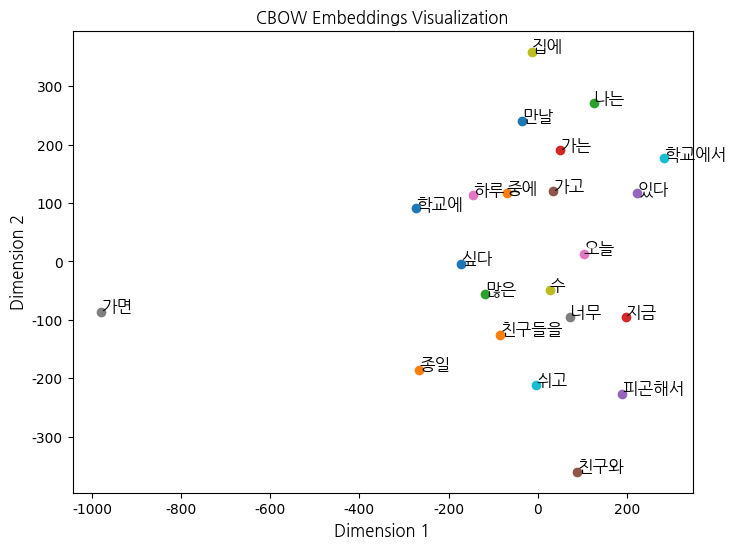

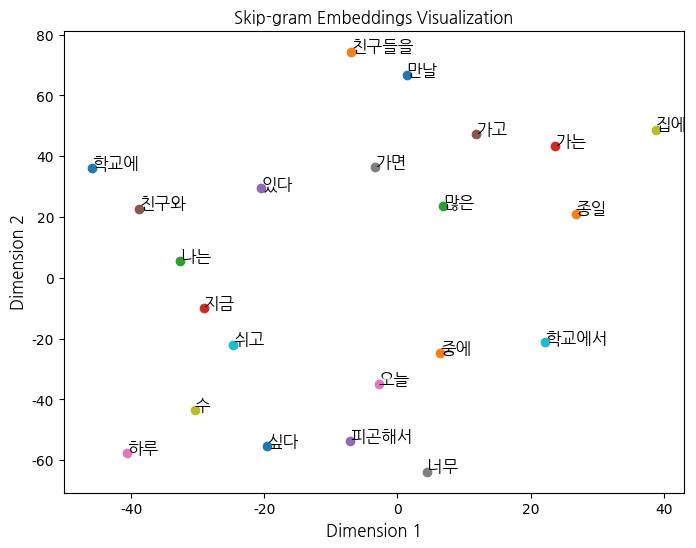

In [27]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from sklearn.manifold import TSNE
import matplotlib as mpl

# 폰트 조절
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_prop = fm.FontProperties(fname = font_path, size = 12)
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['NanumGothic'] + mpl.rcParams['font.sans-serif']
mpl.rcParams['axes.unicode_minus'] = False

def plot_embeddings(embeddings, ix_to_word, title, font_prop):
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt

    n_samples = embeddings.shape[0]
    perplexity = min(5, n_samples - 1)  # t-SNE의 perplexity는 n_samples보다 작아야 함

    tsne = TSNE(n_components = 2, random_state = 0, perplexity = perplexity)
    reduced_embeddings = tsne.fit_transform(embeddings)

    plt.figure(figsize=(8, 6))
    for i, (x, y) in enumerate(reduced_embeddings):
        plt.scatter(x, y)
        plt.annotate(ix_to_word[i], (x, y), fontproperties=font_prop)
    plt.title(title, fontproperties=font_prop)
    plt.xlabel('Dimension 1', fontproperties=font_prop)
    plt.ylabel('Dimension 2', fontproperties=font_prop)
    plt.show()

# CBOW 임베딩 시각화
plot_embeddings(cbow_embeddings, ix_to_word, "CBOW Embeddings Visualization", font_prop=font_prop)
print()
# Skip-gram 임베딩 시각화
plot_embeddings(skipgram_embeddings, ix_to_word, "Skip-gram Embeddings Visualization", font_prop=font_prop)
